In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
style.use('ggplot')

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


#### Get the CESM tseries files for nutrients and other vars

In [2]:
case = 'g.e22b05.G1850ECOIAF_JRA.TL319_g17.002'

In [3]:
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'

In [4]:
variables = ['NO3', 'PO4','O2','SiO3','POC_FLUX_100m','photoC_TOT_zint','photoC_sp_zint','photoC_diat_zint','photoC_diaz_zint']

In [5]:
%%time

ds_list = []

print(f'reading {case}')

ds = xr.Dataset()

for v in variables:
    
    print(v)

    files = sorted(glob(f'{path}/{case}.annual.{v}.????-????.nc'))       

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22b05.G1850ECOIAF_JRA.TL319_g17.002
NO3
PO4
O2
SiO3
POC_FLUX_100m
photoC_TOT_zint
photoC_sp_zint
photoC_diat_zint
photoC_diaz_zint
CPU times: user 15.1 s, sys: 3.42 s, total: 18.6 s
Wall time: 25.7 s


#### Get the World Ocean Atlas dataset that has been interpolated onto the POP grid

In [6]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc'

In [7]:
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)

In [8]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
area_m=ds_woa.TAREA * 1e-4

ds_woa['z_t']=ds.z_t
depths_m=ds_woa.z_t * 0.01
dz=ds_woa.dz
dz_m=ds_woa.dz * 0.01
years = np.arange(len(ds.time))

In [9]:
tlen=len(ds.time)
tlen

122

#### Set up region mask for major basins

In [10]:
grid_name = 'POP_gx1v7'
ds_regmasks = pop_tools.get_grid(grid_name)

In [11]:
pop_tools.list_region_masks(grid_name)

['lat-range-basin', 'Pacific-Indian-Atlantic']

In [12]:
region_masks = pop_tools.list_region_masks(grid_name)
region_mask='Pacific-Indian-Atlantic'
mask3d_basins = pop_tools.region_mask_3d(grid_name, mask_name=region_mask)

In [13]:
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

#### -------------------------------------------------------------------------- end of setup

### NPP

In [14]:
variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'TOT']]

ds_glb = xr.Dataset()
for v in variables:
    ds_glb[v] = esmlab.statistics.weighted_sum(ds[v], weights=area, dim=['nlat', 'nlon'])
    ds_glb[v].attrs = ds[v].attrs

    #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_glb = ds_glb.compute()
#ds_glb

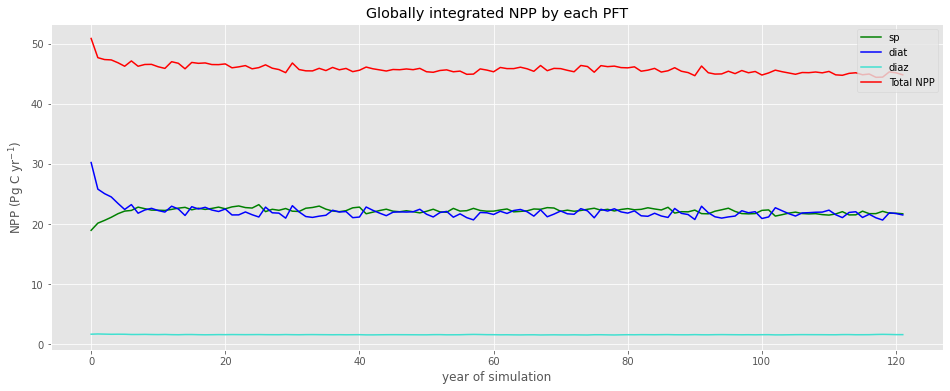

In [15]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(1,1,1)
ax.set_title('Globally integrated NPP by each PFT')
ax.plot(years,ds_glb['photoC_sp_zint'],color='green',label='sp')
ax.plot(years,ds_glb['photoC_diat_zint'],color='blue',label='diat')
ax.plot(years,ds_glb['photoC_diaz_zint'],color='turquoise',label='diaz')
ax.plot(years,ds_glb['photoC_TOT_zint'],color='red',label='Total NPP')

ax.set(ylabel='NPP (Pg C yr$^{-1}$)',xlabel='year of simulation')
ax.legend();

### POC flux

In [16]:
ds_glb['POC_FLUX_100m'] = esmlab.statistics.weighted_sum(ds['POC_FLUX_100m'], weights=area, dim=['nlat', 'nlon'])
ds_glb['POC_FLUX_100m'] = ds_glb['POC_FLUX_100m'] * nmols_to_PgCyr   

[Text(0, 0.5, 'POC flux at 100m (Pg C yr$^{-1}$)'),
 Text(0.5, 0, 'year of simulation')]

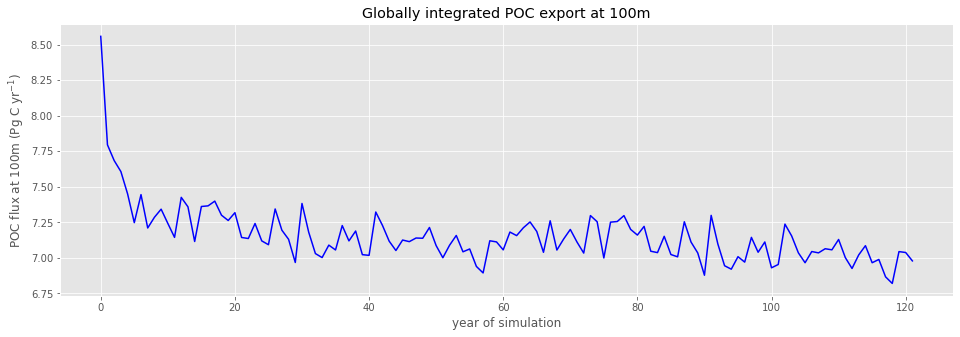

In [17]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Globally integrated POC export at 100m')
ax.plot(years,ds_glb['POC_FLUX_100m'],color='blue')
ax.set(ylabel='POC flux at 100m (Pg C yr$^{-1}$)',xlabel='year of simulation')

## Hovmöller diagrams of nutient/O2 biases (depth versus time)

#### WOA for making biases

In [18]:
woa_Pac = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
regnum=2
woa_Pac['O2'] = esmlab.weighted_mean(ds_woa['O2']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Pac['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Pac['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Pac['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

In [19]:
woa_Atl = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
regnum=1
woa_Atl['O2'] = esmlab.weighted_mean(ds_woa['O2']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Atl['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Atl['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Atl['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

In [20]:
woa_global = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
woa_global['O2'] = esmlab.weighted_mean(ds_woa['O2'], weights=area, dim=['nlat', 'nlon']).compute()
woa_global['NO3'] = esmlab.weighted_mean(ds_woa['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
woa_global['PO4'] = esmlab.weighted_mean(ds_woa['PO4'], weights=area, dim=['nlat', 'nlon']).compute()
woa_global['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()

In [21]:
woa_SO = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
woa_SO['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
woa_SO['O2'] = esmlab.weighted_mean(ds_woa['O2'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
woa_SO['NO3'] = esmlab.weighted_mean(ds_woa['NO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
woa_SO['PO4'] = esmlab.weighted_mean(ds_woa['PO4'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()

#### CESM timeseries: Pacific, Alantic, global, Southern Ocean

Southern Ocean

In [22]:
ts_SO = xr.Dataset({v: ds[v] for v in ['time','z_t']})
ts_SO['SiO3'] = esmlab.weighted_mean(ds['SiO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO['O2'] = esmlab.weighted_mean(ds['O2'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO['PO4'] = esmlab.weighted_mean(ds['PO4'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO['NO3'] = esmlab.weighted_mean(ds['NO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()

In [23]:
diff_SO = ts_SO - woa_SO
diff_SO=diff_SO.transpose()
diff_SO_top=diff_SO.isel(z_t=slice(0,40))
diff_SO_bottom=diff_SO.isel(z_t=slice(40,60))

Pacific

In [24]:
%%time
regnum=2
ts_Pac = xr.Dataset({v: ds[v] for v in ['time','z_t']})
ts_Pac['O2'] = esmlab.weighted_mean(ds['O2']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac['PO4'] = esmlab.weighted_mean(ds['PO4']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac['NO3'] = esmlab.weighted_mean(ds['NO3']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac['SiO3'] = esmlab.weighted_mean(ds['SiO3']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 1min 4s, sys: 1min 34s, total: 2min 39s
Wall time: 2min 40s


In [25]:
diff_Pac = ts_Pac - woa_Pac
diff_Pac=diff_Pac.transpose()
diff_Pac_top=diff_Pac.isel(z_t=slice(0,40))
diff_Pac_bottom=diff_Pac.isel(z_t=slice(40,60))

Atlantic

In [26]:
%%time
regnum=1
ts_Atl = xr.Dataset({v: ds[v] for v in ['time','z_t']})
ts_Atl['O2'] = esmlab.weighted_mean(ds['O2']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl['PO4'] = esmlab.weighted_mean(ds['PO4']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl['NO3'] = esmlab.weighted_mean(ds['NO3']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl['SiO3'] = esmlab.weighted_mean(ds['SiO3']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 1min 4s, sys: 1min 27s, total: 2min 31s
Wall time: 2min 38s


In [27]:
diff_Atl = ts_Atl - woa_Atl
diff_Atl=diff_Atl.transpose()
diff_Atl_top=diff_Atl.isel(z_t=slice(0,40))
diff_Atl_bottom=diff_Atl.isel(z_t=slice(40,60))

Global

In [28]:
%%time
ts_global = xr.Dataset({v: ds[v] for v in ['time','z_t']})
ts_global['O2'] = esmlab.weighted_mean(ds['O2'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global['PO4'] = esmlab.weighted_mean(ds['PO4'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global['NO3'] = esmlab.weighted_mean(ds['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global['SiO3'] = esmlab.weighted_mean(ds['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 46.8 s, sys: 58.7 s, total: 1min 45s
Wall time: 2min 5s


In [29]:
diff_global = ts_global - woa_global
diff_global=diff_global.transpose()
diff_global_top=diff_global.isel(z_t=slice(0,40))
diff_global_bottom=diff_global.isel(z_t=slice(40,60))

#### Set up dims for plotting

In [30]:
z_top=depths_m.isel(z_t=slice(0,40))
z_bottom=depths_m.isel(z_t=slice(40,60))

## O$_2$

#### Plot Pacific O$_2$ bias

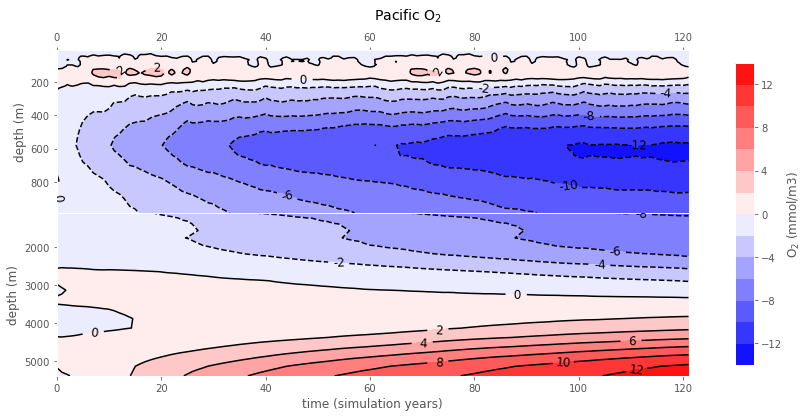

In [31]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific O$_2$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14]
pc=ax.contourf(years, z_top, diff_Pac_top['O2'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Pac_top['O2'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac_bottom['O2'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Pac_bottom['O2'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='O$_2$ (mmol/m3)')

#### Plot Atlantic O2 bias

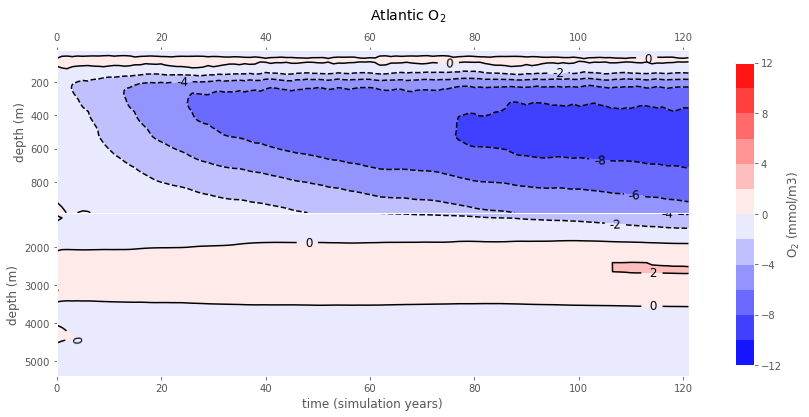

In [32]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Atlantic O$_2$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12]
pc=ax.contourf(years, z_top, diff_Atl_top['O2'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Atl_top['O2'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Atl_bottom['O2'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Atl_bottom['O2'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='O$_2$ (mmol/m3)')

#### Plot Global O2 bias

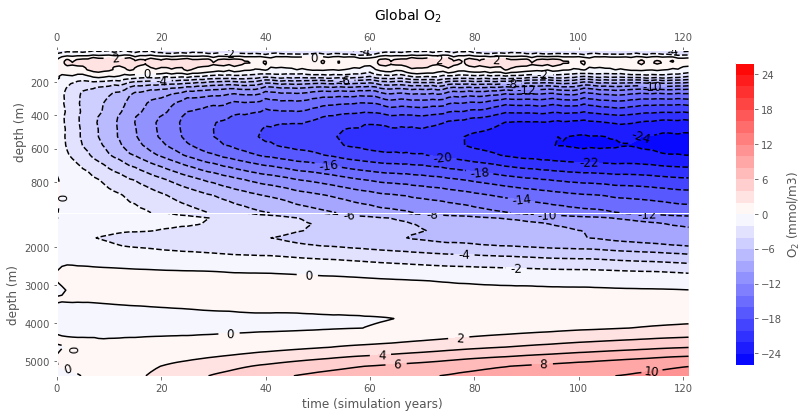

In [33]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Global O$_2$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-26,-24,-22,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20,22,24,26]
pc=ax.contourf(years, z_top, diff_global_top['O2'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_global_top['O2'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_global_bottom['O2'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_global_bottom['O2'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='O$_2$ (mmol/m3)')

## NO$_3$

#### Plot Pacific NO$_3$ bias

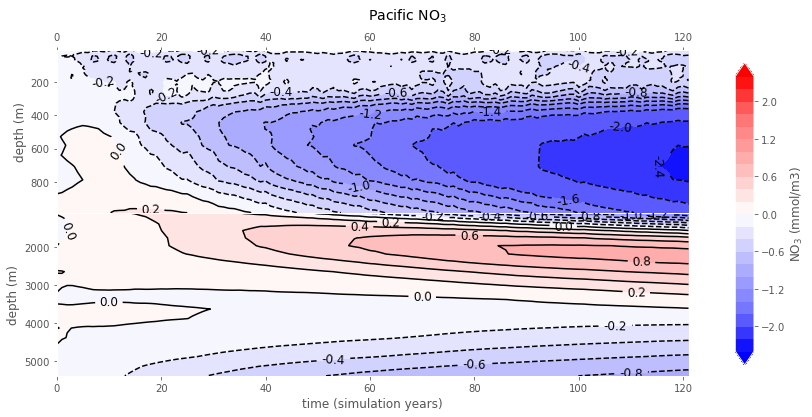

In [34]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific NO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-2.8,-2.4,-2,-1.6,-1.4,-1.2,-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,2,2.4,2.8]
pc=ax.contourf(years, z_top, diff_Pac_top['NO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_Pac_top['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac_bottom['NO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_Pac_bottom['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='NO$_3$ (mmol/m3)',extend='both')

#### Plot Atlantic NO$_3$ bias

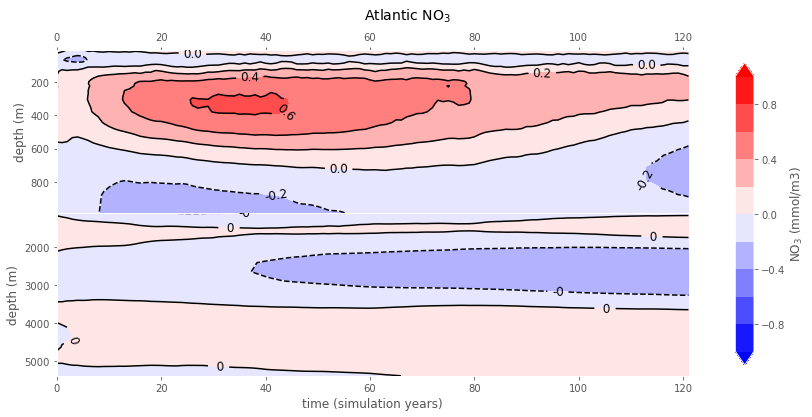

In [35]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Atlantic NO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1]
pc=ax.contourf(years, z_top, diff_Atl_top['NO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_Atl_top['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Atl_bottom['NO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_Atl_bottom['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='NO$_3$ (mmol/m3)',extend='both')

#### Global NO$_3$ bias

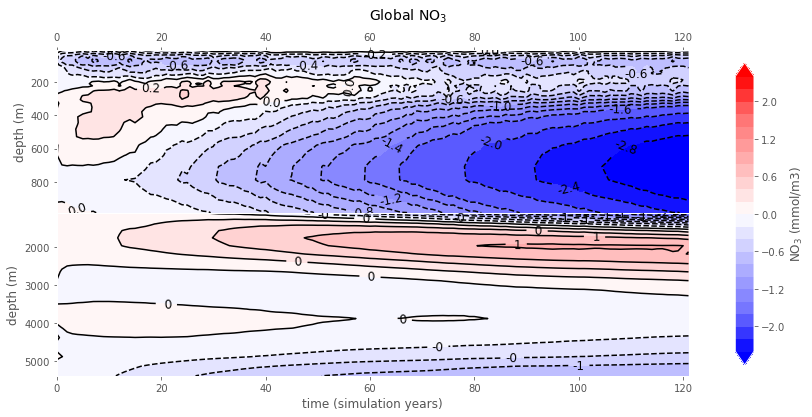

In [36]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Global NO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-2.8,-2.4,-2,-1.6,-1.4,-1.2,-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,2,2.4,2.8]
pc=ax.contourf(years, z_top, diff_global_top['NO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_global_top['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_global_bottom['NO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_global_bottom['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='NO$_3$ (mmol/m3)',extend='both')

## SiO$_3$

#### Atlantic SiO$_3$ bias

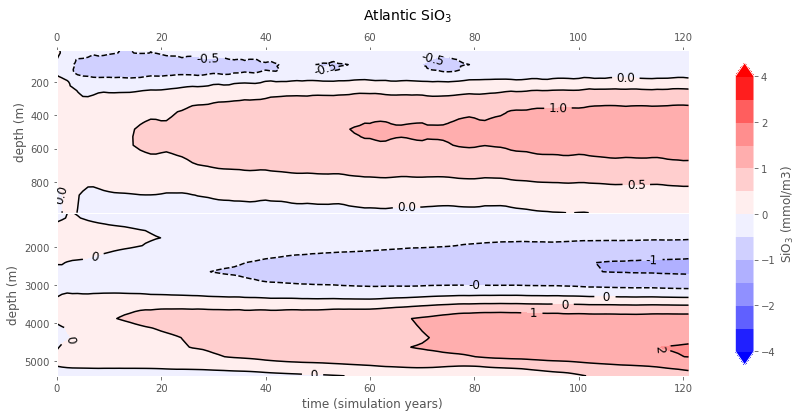

In [37]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Atlantic SiO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-4, -3,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3,4]
pc=ax.contourf(years, z_top, diff_Atl_top['SiO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_Atl_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Atl_bottom['SiO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_Atl_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ (mmol/m3)',extend='both')

#### Pacific SiO$_3$ bias

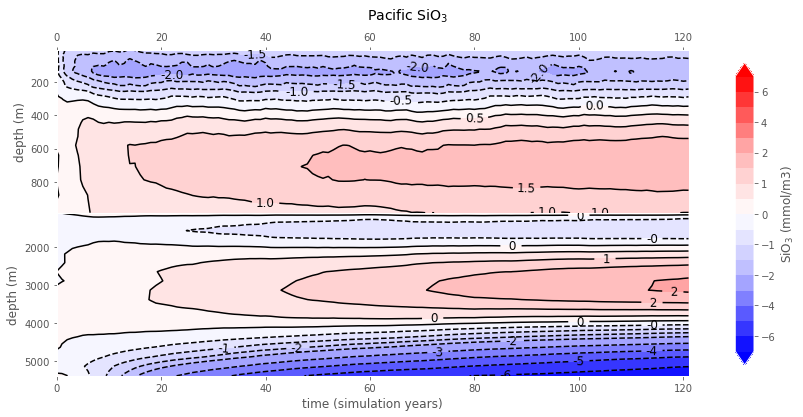

In [38]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific SiO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4, -3,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_Pac_top['SiO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_Pac_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac_bottom['SiO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_Pac_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ (mmol/m3)',extend='both')

#### Global SiO$_3$ bias

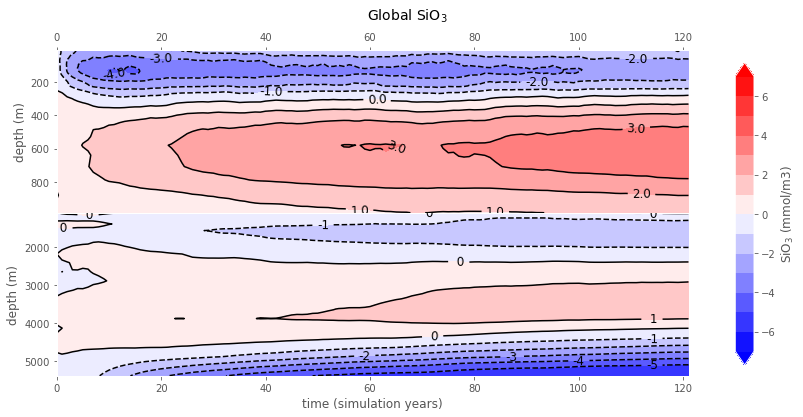

In [39]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Global SiO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_global_top['SiO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_global_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_global_bottom['SiO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_global_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ (mmol/m3)',extend='both')

### Southern Ocean SiO$_3$ bias

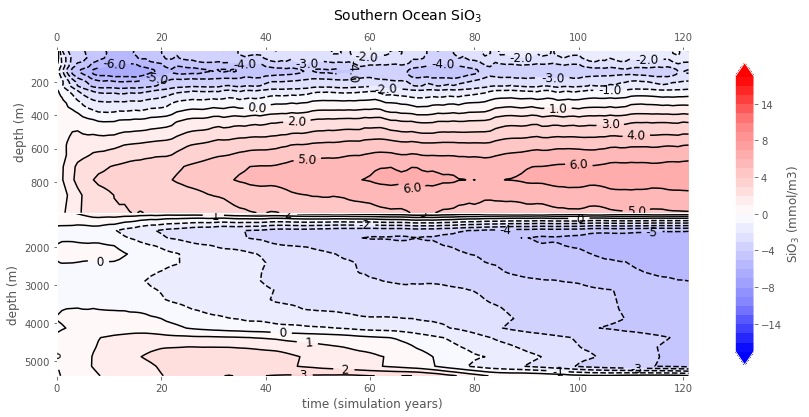

In [40]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Southern Ocean SiO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-20,-18,-16,-14,-12,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,12,14,16,18,20]
pc=ax.contourf(years, z_top, diff_SO_top['SiO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_SO_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_SO_bottom['SiO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_SO_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ (mmol/m3)',extend='both')

## PO$_4$

#### Atlantic PO$_4$ bias

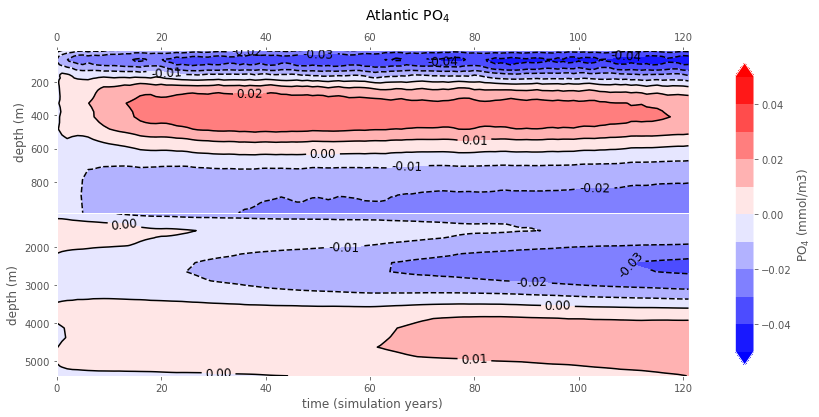

In [41]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Atlantic PO$_4$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05]
pc=ax.contourf(years, z_top, diff_Atl_top['PO4'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_Atl_top['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Atl_bottom['PO4'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_Atl_bottom['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='PO$_4$ (mmol/m3)',extend='both')

#### Pacific PO$_4$ bias

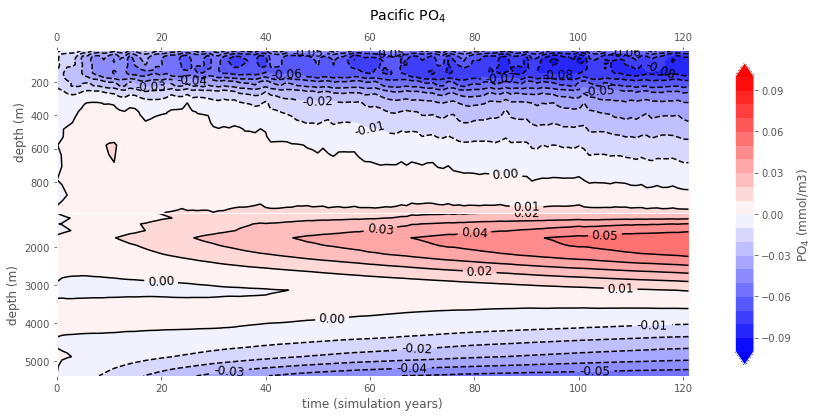

In [42]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific PO$_4$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-0.1,-0.09,-0.08,-0.07,-0.06,-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
pc=ax.contourf(years, z_top, diff_Pac_top['PO4'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_Pac_top['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac_bottom['PO4'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_Pac_bottom['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='PO$_4$ (mmol/m3)',extend='both')

#### Global PO$_4$ bias

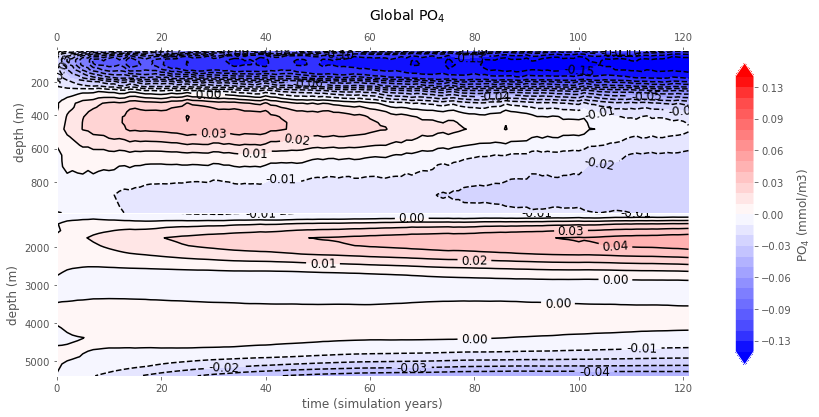

In [43]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Global PO$_4$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-0.15,-0.13,-0.11,-0.1,-0.09,-0.08,-0.07,-0.06,-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.13,0.15]
pc=ax.contourf(years, z_top, diff_global_top['PO4'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_global_top['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_global_bottom['PO4'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_global_bottom['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='PO$_4$ (mmol/m3)',extend='both')